In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from data_utils.dataset import ChangeDetectionDataset
from utils.models import FCSiamDiff, FCEF


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 8

train_dir = "./data/train"
val_dir = "./data/val"
test_dir = "./data/test"

data_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

train_dataset = ChangeDetectionDataset(train_dir, data_transforms)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

val_dataset = ChangeDetectionDataset(val_dir, data_transforms)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True
)

test_dataset = ChangeDetectionDataset(test_dir, data_transforms)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True
)

lr = 3e-4
num_epoches = 10

net = FCEF().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr)

loss_func = nn.BCEWithLogitsLoss()

In [2]:
l_his = []

for epoch in range(num_epoches):
    print("Epoch:", epoch + 1, "Training...")
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):

        x, labels = data["x"], data["mask"]

        x = x.to(device)
        labels = labels.to(device)

        x, labels = (
            Variable(x),
            Variable(labels.float()),
        )

        optimizer.zero_grad()
        f1 = net(x)
        loss = loss_func(f1, labels)
        loss.backward()
        optimizer.step()
        if i % 5 == 4:
            l_his.append(loss.item())
        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:
            print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

Epoch: 1 Training...
[1,    50] loss: 0.535
[1,   100] loss: 0.489
[1,   150] loss: 0.481
[1,   200] loss: 0.475
[1,   250] loss: 0.472
[1,   300] loss: 0.465
[1,   350] loss: 0.463
[1,   400] loss: 0.457
[1,   450] loss: 0.454
[1,   500] loss: 0.451
[1,   550] loss: 0.446
[1,   600] loss: 0.442
[1,   650] loss: 0.438
[1,   700] loss: 0.434
[1,   750] loss: 0.430
[1,   800] loss: 0.425
[1,   850] loss: 0.423
Epoch: 2 Training...
[2,    50] loss: 0.416
[2,   100] loss: 0.412
[2,   150] loss: 0.408
[2,   200] loss: 0.404
[2,   250] loss: 0.401
[2,   300] loss: 0.398
[2,   350] loss: 0.394
[2,   400] loss: 0.390
[2,   450] loss: 0.387
[2,   500] loss: 0.383
[2,   550] loss: 0.380
[2,   600] loss: 0.376
[2,   650] loss: 0.374
[2,   700] loss: 0.370
[2,   750] loss: 0.367
[2,   800] loss: 0.363
[2,   850] loss: 0.360
Epoch: 3 Training...
[3,    50] loss: 0.354
[3,   100] loss: 0.351
[3,   150] loss: 0.348
[3,   200] loss: 0.345
[3,   250] loss: 0.342
[3,   300] loss: 0.339
[3,   350] loss: 

Finished Training


Text(0, 0.5, 'Loss')

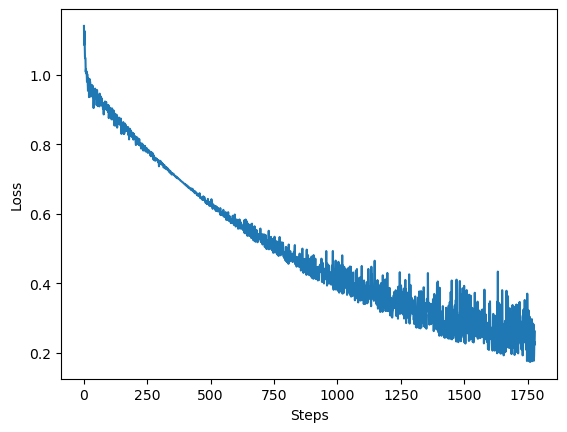

In [4]:

print("Finished Training")
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(l_his)
plt.xlabel("Steps")
plt.ylabel("Loss")
# fig.savefig("plott2.png")

[0.]
[0.]


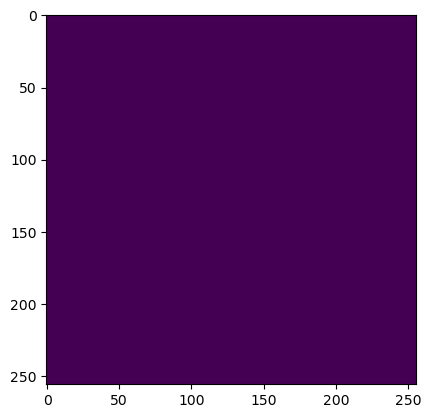

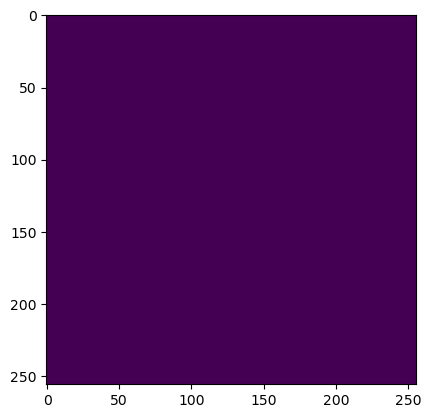

[0.]
[0.]


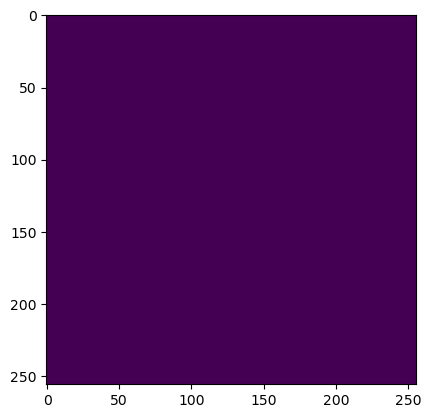

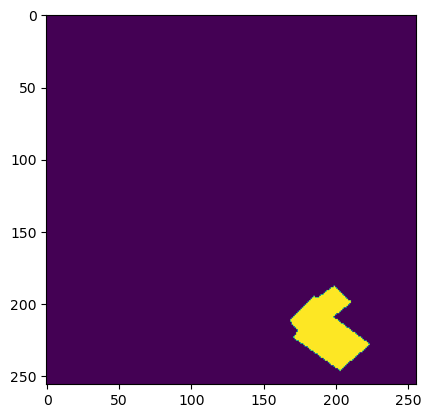

[0.]
[0.]


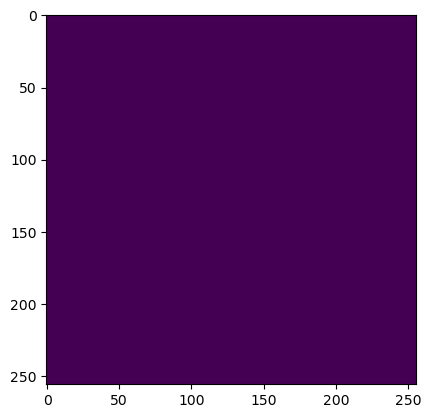

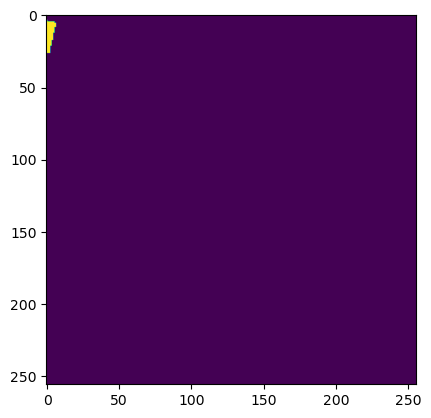

[0.]
[0.]


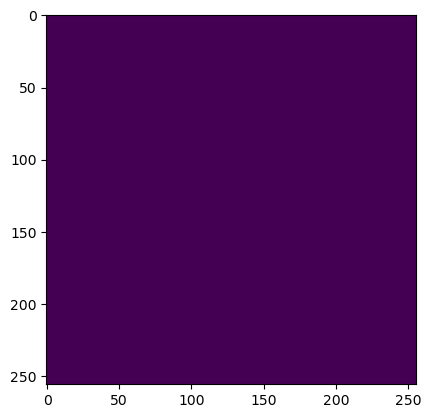

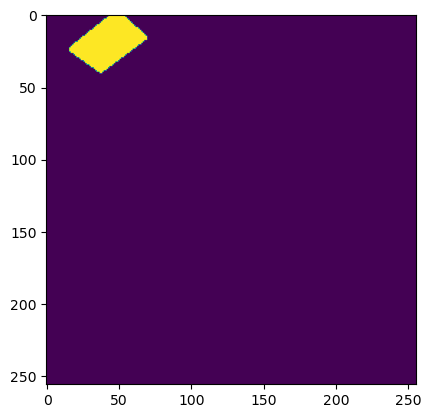

[0.]
[0.]


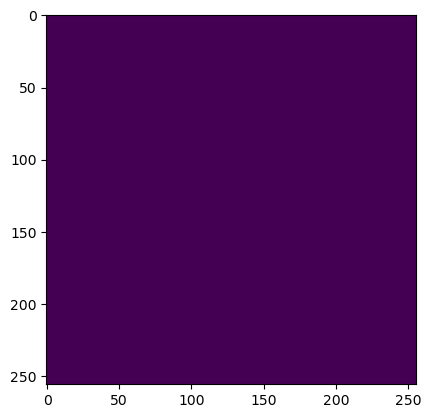

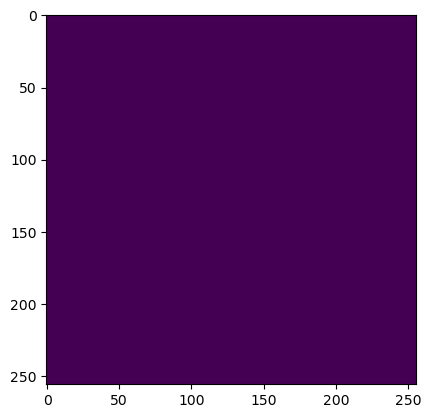

[0.]
[0.]


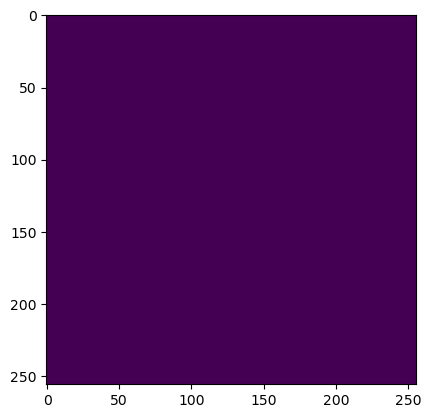

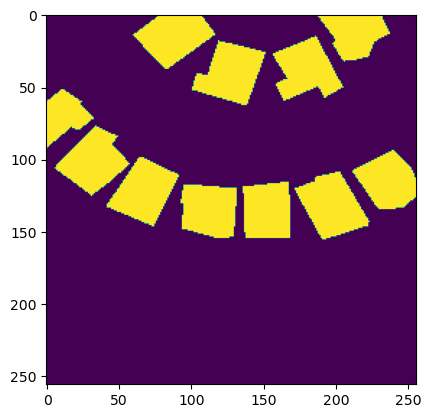

[0.]
[0.]


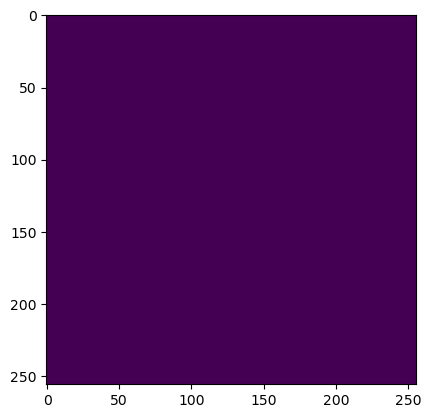

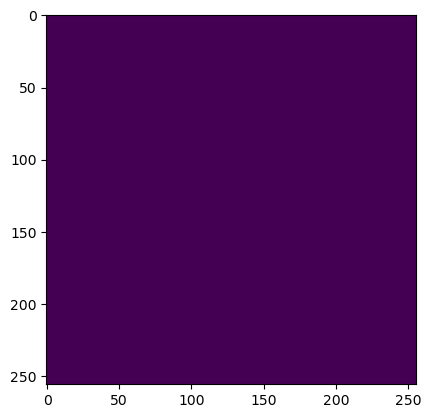

[0.]
[0.]


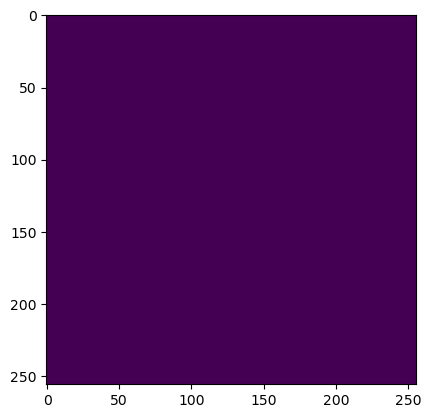

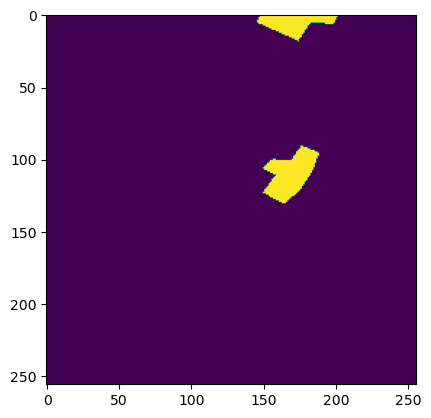

[0.]
[0.]


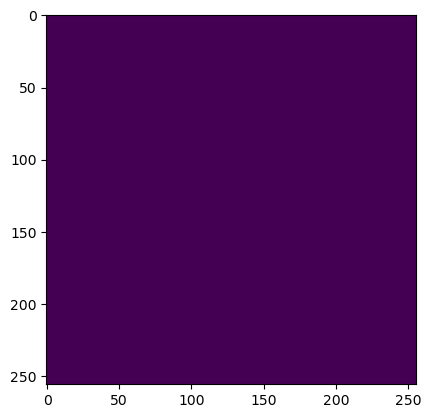

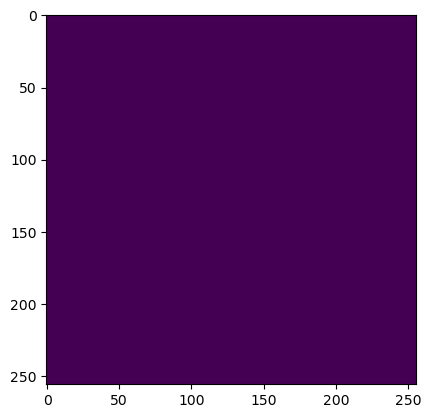

[0.]
[0.]


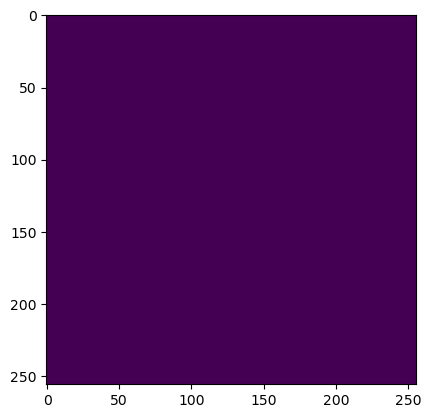

KeyboardInterrupt: 

In [6]:
import torchmetrics
num_classes = 2

# metrics = torchmetrics.MetricCollection({
#     'acc': torchmetrics.Accuracy(task='binary'),
#     'prec': torchmetrics.Precision(task='binary',num_classes=2, average='macro'),
#     'rec': torchmetrics.Recall(task='binary',num_classes=2, average='macro'),
#     "iou": torchmetrics.JaccardIndex(task='binary')
# }).to(device)

for i, data in enumerate(val_dataloader, 0):

        x, labels = data["x"], data["mask"]

        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            f1 = net(x)
            # acc = metrics(f1, labels)
            f1 = torch.round(torch.sigmoid(f1)).cpu().detach().numpy()

        for i in range(4):
            plt.figure()
            # print(np.unique(f1[i][0]))
            plt.imshow(f1[i][0])
            plt.figure()
            plt.imshow(labels.cpu().numpy()[i][0])
            # print(np.unique(f1[i][0]))
            plt.show(block=False)

# acc = metrics.compute()
# print(acc)